## PYPSA-USA Technical Appendix

PYPSA-USA Repository: https://github.com/PyPSA/pypsa-usa/tree/master


### PYPSA-USA Data Sources 

|Input Data | Description | Source |
| --- | --- | --- |
|BA_Shapes_new| Shape file used as inputs to produce geojson images. The shape file inputs return country and state boundary geojson .png files. | PYPSA-USA Repository | 
| BOEM_CA_OSW_GIS| Shape file used as inputs to produce geojson images. The shape file inputs are specific to California and return onshore and offshore wind geojson .png files.| PYPSA-USA Repository|
|NERC_Regions| Shape file used as input to produce geojson images for each NERC region and subregion.| PYPSA-USA Repository|
|carbonconstraints | Data files that contain information on carbon capture rates for different types of coal and gas plants. Additionally, data is provided on carbon cap, carbon tax, methane leakage, and penalty rates.| ReEDS Constraints - PYPSA-USA Repository|
|national_generation| General mandated technology list accompanied with a general mandated technology trajectory forecast up to 2040.|ReEDS Constraints - PYPSA-USA Repository|
|reserves| Estimates on static and ramping levels at the balancing authority level (nercr) up to 2050.|ReEDS Constraints - PYPSA-USA Repository|
|state_policies| Variety of state level data for energy mandates, offshore requirements and banned technologies.| ReEDS Constraints - PYPSA-USA Repository|
|Transmissions| https://github.com/PyPSA/pypsa-usa/blob/master/workflow/repo_data/ReEDS_Constraints/transmission/README.md | ReEDS Constraints - PYPSA-USA Repository|
|membership| Data file containing NERC memberships at the transmission group level.| ReEDS Constraints - PYPSA-USA Repository|
|Reeds_Shapes| Shape file used as an input to produce geojson images for Reeds regions.| PYPSA-USA Repository|
|Locational_Mulipliers|-	Data files that contain project cost estimates for various energy requirements at Reeds regional multiplier locations.| PYPSA-USA Repository|
|Plants| Data files for ADS plant locations, EIA 860 and ADS merged plants, other plants that have merged, fuels costs for 2022, and WECC fuel regions.| PYPSA-USA Repository|
|Retrieve_casio_data| Historical daily natural gas fuel prices are retrieved from CAISO's Open Access Same-time Information System (OASIS). Data is collected on a daily basis for each Balancing Area and Fuel Region that had joined the Western Energy Imbalance Market (WEIM) during the time period designated in the configuration.| http://oasis.caiso.com/mrioasis/logon.do|
|Retrieve_cost_data_eur| Pulls cost data from PYPSA-EU (Source is unclear at the moment)| |
|Retrieve_cost_data_usa| Retrieves cost data for USA. The script starts by pulling NREL ATB power generation data for a specified year (atb_year) then NREL ATB transportation data is collected. |https://oedi-datalake.s3.amazonaws.com/ATB/electricity/parquet/{atb_year}/ATBe.parquet, https://atb-archive.nrel.gov/transportation/2020/files/2020_ATB_Data_VehFuels_Download.xlsx|
|Retrieve_databundles| Pulls NREL EFS load profile zip files. The load profiles represent projected end-use electricity demand for various scenarios of electrification (Reference, Medium, High) and technology advancement (Slow, Moderate, Rapid), developed using the EnergyPATHWAYS (EP) model, as described in Mai et al. (2018). The EP load profiles were further calibrated for use in the ReEDS capacity expansion model (detailed in forthcoming EFS analyses), thus numerical values in this data set differ slightly from those reported in Mai et al. (2018). Load profiles are provided for a subset of years (2018, 2020, 2024, 2030, 2040, 2050) and are aggregated to the state, sector, and select subsector level.| https://data.nrel.gov/submissions/126|
|Retrieve_eulp| Module to download end use load profiles (eulp) for comstock and restock data. Data is downloaded at the state level, multisector 15 minute load profiles for a year which is fixed on 2018 Amy weather data.| https://data.openei.org/submissions/4520|
|Retrieve_forcast_data| Download forecast data from external sources (CEC, WECC). Files contain hourly forecast results developed as part of the California Energy Commission's 2022 Integrated Energy Policy Report Update.| https://efiling.energy.ca.gov/GetDocument.aspx?tn=248357, https://efiling.energy.ca.gov/GetDocument.aspx?tn=248355, https://efiling.energy.ca.gov/GetDocument.aspx?tn=248353, https://www.wecc.org/Reliability/WECC%202030%20ADS%20PCM%202020-12-16%20(V1.5)%20Public%20Data.zip, https://www.wecc.org/Reliability/2032%20ADS%20PCM%20V2.3.2%20Public%20Data.zip|
|Retrieve_gridemissions_data| Historical electrical generation, demand, interchange, and emissions data are retrieved from the GridEmissions. Data is downloaded at hourly temporal resolution and at a spatial resolution of balancing authority region.|https://gridemissions.jdechalendar.su.domains/#/code.| 


In [2]:
# Import libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import pypsa
import gdown
import os
import sys
import netCDF4 as nc
import scipy
import cartopy.io.shapereader as shpreader
import geopandas as gpd
import matplotlib.pyplot as plt
import atlite
import xarray as xr
import cartopy.crs as ccrs
from cartopy.crs import PlateCarree as plate
import cartopy.io.shapereader as shpreader

from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches
from matplotlib.lines import Line2D
from pypsa.statistics import StatisticsAccessor, get_bus_and_carrier

In [3]:
# Ensure that the pypsa-usa_technical_appendix.ipynb file is saved within the "workflow" folder of the PYPSA-USA repository.
current_dir = os.path.dirname(os.path.abspath('pypsa-usa_technical_appendix.ipynb'))

# Define path to scripts subfolder within the PYPSA-USA repository
subfolder_path = os.path.join(current_dir, 'scripts')
sys.path.append(subfolder_path)


In [1004]:
# Import network
network = pypsa.Network()

# UPDATE to user specific file path
file_path = "C:/Users/alexa/Policy_Integrity/elec_s_145_ec_lv1.0_Ep_E_operations.nc" 

# Import network from file
network.import_from_netcdf(path=file_path)


INFO:pypsa.io:Imported network elec_s_145_ec_lv1.0_Ep_E_operations.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units


In [1002]:
# Import data for USA plot
buses = network.buses
carriers = network.carriers
generators = network.generators
storage_units = network.storage_units
lines = network.lines
links = network.links

# Create a series for the size of buses in the network
bus_sizes = generators.groupby("bus").p_nom_opt.sum()
line_values = lines.s_nom_opt
link_values = links.p_nom_opt

In [1005]:
# Generate geopandas state boarders for capacity and demand maps.
STATES_TO_REMOVE = [
    "Hawaii",
    "Alaska",
    "Commonwealth of the Northern Mariana Islands",
    "United States Virgin Islands",
    "Guam",
    "Puerto Rico",
    "American Samoa",
]

shpfilename = shpreader.natural_earth(
    resolution="10m", category="cultural", name="admin_1_states_provinces"
)
reader = shpreader.Reader(shpfilename)
gdf_states = reader.records()
data = []
for r in gdf_states:
    attr = r.attributes
    if (attr["iso_a2"] in ["US"]) and (attr["name"] not in STATES_TO_REMOVE):
        data.append(
            [
                attr["name"],
                attr["iso_a2"],
                attr["latitude"],
                attr["longitude"],
                r.geometry,
            ]
        )
gdf_states = gpd.GeoDataFrame(
    data, columns=["name", "country", "x", "y", "geometry"]
).set_crs(4326)

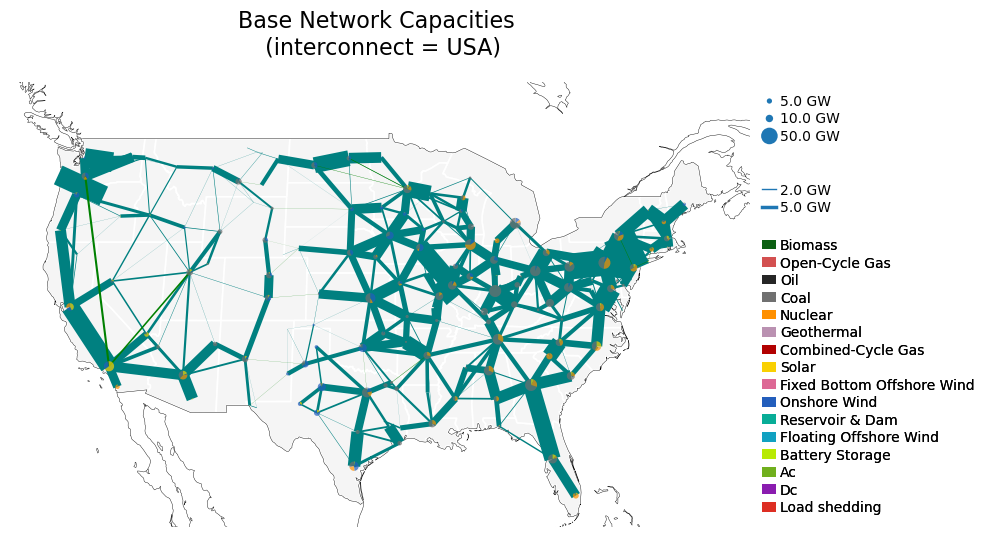

In [1025]:
# Import capacity plot function from pypsa-usa scripts.
from plot_network_maps import plot_base_capacity_map, get_capacity_base

# Prevent legends from overlapping
plt.rcParams["legend.labelspacing"] = .25
plt.rcParams["legend.handlelength"] = 1
plt.rcParams["legend.handletextpad"] = .25

# Plot capacity map
plot_base_capacity_map(
    n=network,
    regions=gdf_states, 
    carriers=["solar", "wind", "onwind", "offwind", "ror", "nuclear", "gas", "coal", "battery"],
    save="C:/Users/alexa/Policy_Integrity/figures/USA_capacity_map.png", # chnage to users file path
    interconnect="USA",
)


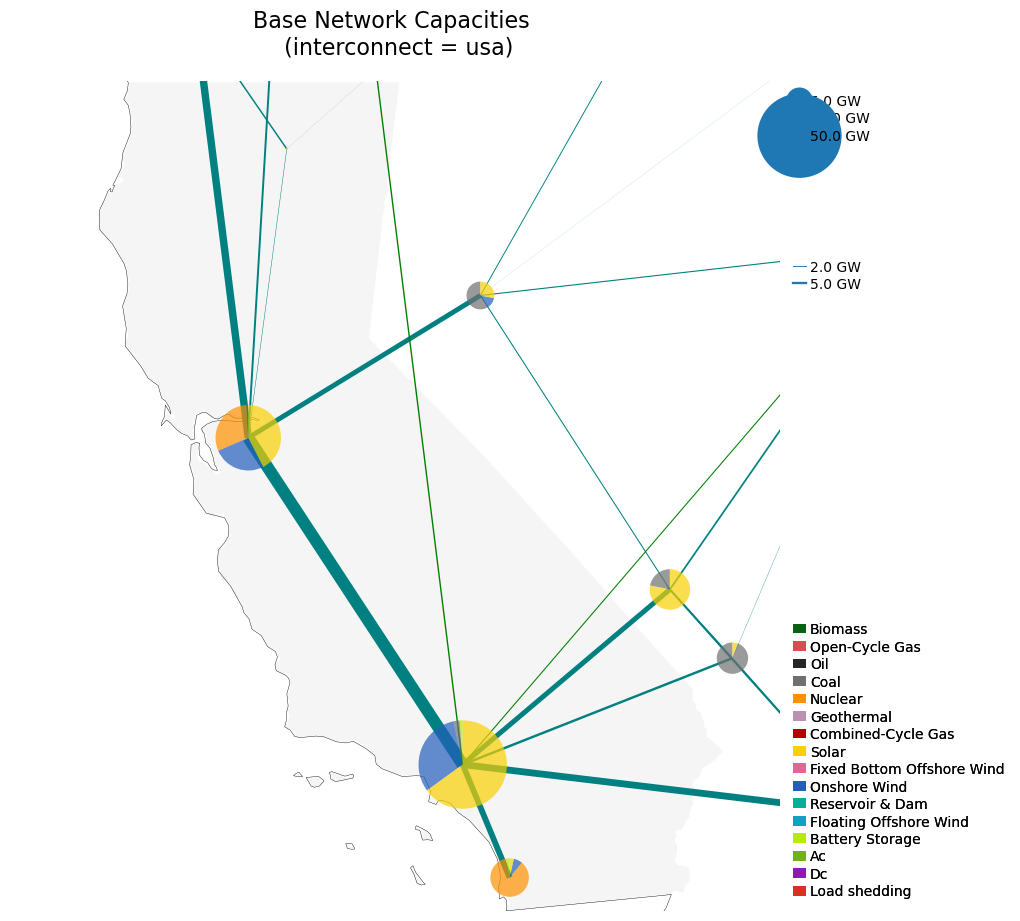

In [1026]:
# Example of zooming in on particular state (California). To update, chanage "name == 'STATE'" to desired location. 

plot_base_capacity_map(
    n=network,
    regions=gdf_states.query("name == 'California'"), 
    carriers=["solar", "wind", "onwind", "offwind", "ror", "nuclear", "gas", "coal", "battery"],
    save="C:/Users/alexa/Policy_Integrity/figures/USA_capacity_map.png",
    interconnect="usa",
)

## Summary of Input Data

### Energy Supply Statistics 

In [1037]:
# primary energy (i.e. before conversion with losses by generators)
def get_primary_energy_use(n: pypsa.Network) -> pd.DataFrame:
    """
    Gets timeseries primary energy use by bus and carrier.
    """

    link_energy_use = (
        StatisticsAccessor(n)
        .withdrawal(
            comps=["Link", "Store", "StorageUnit"],
            aggregate_time=False,
            groupby=get_bus_and_carrier,
        )
        .droplevel("component")
    )

    gen_dispatch = (
        StatisticsAccessor(n)
        .supply(
            aggregate_time=False,
            comps=["Generator"],
            groupby=pypsa.statistics.get_name_bus_and_carrier,
        )
        .droplevel("component")
    )
    gen_eff = n.get_switchable_as_dense("Generator", "efficiency")

    gen_energy_use = gen_dispatch.T.mul(1 / gen_eff, axis=0, level="name").T.droplevel(
        "name",
    )

    return (
        pd.concat([gen_energy_use, link_energy_use])
        .groupby(["bus", "carrier"])
        .sum()
    )

energy_use = get_primary_energy_use(network)

# Add zonal features to energy use dataframe 
def add_zonal_features(energy_use: pd.DataFrame, buses: pd.DataFrame):
    """
    Returns energy_use dataframe with additional zonal features from buses dataframe.
    """
    buses_select = (buses[["reeds_zone", "reeds_ba", "interconnect", "reeds_state"]]
                    .reset_index()
                    .rename(columns={"Bus": "bus"}))

    energy_use_zonal = energy_use.reset_index()

    energy_use_zonal.columns = energy_use_zonal.columns.droplevel(1)

    energy_use_zonal = (energy_use_zonal.merge(buses_select, on="bus")
                                        .set_index(["bus", "carrier", "reeds_zone", 
                                        "reeds_ba", "interconnect", "reeds_state"]))

    energy_use.columns = [timestamp[1] for timestamp in energy_use.columns]
    energy_use.columns = pd.to_datetime(energy_use.columns)
    energy_use_zonal.columns = energy_use.columns

    return energy_use_zonal

energy_use_zonal = add_zonal_features(energy_use, buses)
energy_use_zonal.head()

2019-01-01 00:00:00  \
bus     carrier         reeds_zone reeds_ba interconnect reeds_state                        
p1000 0 Biomass         p100       PJM      Eastern      VA                      7.897490   
        Load shedding   p100       PJM      Eastern      VA                      0.000041   
        Onshore Wind    p100       PJM      Eastern      VA                      0.000000   
        Open-Cycle Gas  p100       PJM      Eastern      VA                      0.006612   
        Reservoir & Dam p100       PJM      Eastern      VA                      1.276630   

                                                                      2019-01-01 01:00:00  \
bus     carrier         reeds_zone reeds_ba interconnect reeds_state                        
p1000 0 Biomass         p100       PJM      Eastern      VA                      7.897493   
        Load shedding   p100       PJM      Eastern      VA                      0.000041   
        Onshore Wind    p100       PJM      Eastern      VA                      0.000000   
        Open-Cycle Gas  p100       PJM      Eastern      VA                      0.006612   
        Reservoir & Dam p100       PJM      Eastern      VA                      1.052163   

                                                                      2019-01-01 02:00:00  \
bus     carrier         reeds_zone reeds_ba interconnect reeds_state                        
p1000 0 Biomass         p100       PJM      Eastern      VA                      7.897502   
        Load shedding   p100       PJM      Eastern      VA                      0.000041   
        Onshore Wind    p100       PJM      Eastern      VA                      0.000000   
        Open-Cycle Gas  p100       PJM      Eastern      VA                      0.006617   
        Reservoir & Dam p100       PJM      Eastern      VA                      0.736627   

                                                                      2019-01-01 03:00:00  \
bus     carrier         reeds_zone reeds_ba interconnect reeds_state                        
p1000 0 Biomass         p100       PJM      Eastern      VA                      7.897505   
        Load shedding   p100       PJM      Eastern      VA                      0.000041   
        Onshore Wind    p100       PJM      Eastern      VA                      0.000000   
        Open-Cycle Gas  p100       PJM      Eastern      VA                      0.006614   
        Reservoir & Dam p100       PJM      Eastern      VA                      0.481728   

                                                                      2019-01-01 04:00:00  \
bus     carrier         reeds_zone reeds_ba interconnect reeds_state                        
p1000 0 Biomass         p100       PJM      Eastern      VA                      7.897512   
        Load shedding   p100       PJM      Eastern      VA                      0.000041   
        Onshore Wind    p100       PJM      Eastern      VA                      0.000000   
        Open-Cycle Gas  p100       PJM      Eastern      VA                      0.006617   
        Reservoir & Dam p100       PJM      Eastern      VA                      0.478633   

                                                                      2019-01-01 05:00:00  \
bus     carrier         reeds_zone reeds_ba interconnect reeds_state                        
p1000 0 Biomass         p100       PJM      Eastern      VA                      7.897506   
        Load shedding   p100       PJM      Eastern      VA                      0.000041   
        Onshore Wind    p100       PJM      Eastern      VA                      0.000000   
        Open-Cycle Gas  p100       PJM      Eastern      VA                      0.006614   
        Reservoir & Dam p100       PJM      Eastern      VA                      0.467892   

                                                                      2019-01-01 06:00:00  \
bus     carrier         reeds_zone reeds_ba interconnect reeds_st

In [1101]:
# Average monthly energy_use_zonal
energy_use_zonal_monthly = energy_use_zonal.resample("M", axis=1).mean()
energy_use_zonal_monthly.head()

2019-01-31  \
bus     carrier         reeds_zone reeds_ba interconnect reeds_state               
p1000 0 Biomass         p100       PJM      Eastern      VA             7.897582   
        Load shedding   p100       PJM      Eastern      VA             0.000042   
        Onshore Wind    p100       PJM      Eastern      VA             0.000000   
        Open-Cycle Gas  p100       PJM      Eastern      VA             0.006802   
        Reservoir & Dam p100       PJM      Eastern      VA             0.423044   

                                                                      2019-02-28  \
bus     carrier         reeds_zone reeds_ba interconnect reeds_state               
p1000 0 Biomass         p100       PJM      Eastern      VA             7.896903   
        Load shedding   p100       PJM      Eastern      VA             0.000043   
        Onshore Wind    p100       PJM      Eastern      VA             0.000000   
        Open-Cycle Gas  p100       PJM      Eastern      VA             0.007239   
        Reservoir & Dam p100       PJM      Eastern      VA             1.134691   

                                                                      2019-03-31  \
bus     carrier         reeds_zone reeds_ba interconnect reeds_state               
p1000 0 Biomass         p100       PJM      Eastern      VA             7.896673   
        Load shedding   p100       PJM      Eastern      VA             0.000043   
        Onshore Wind    p100       PJM      Eastern      VA             0.000000   
        Open-Cycle Gas  p100       PJM      Eastern      VA             0.006954   
        Reservoir & Dam p100       PJM      Eastern      VA             1.116785   

                                                                      2019-04-30  \
bus     carrier         reeds_zone reeds_ba interconnect reeds_state               
p1000 0 Biomass         p100       PJM      Eastern      VA             7.895599   
        Load shedding   p100       PJM      Eastern      VA             0.000043   
        Onshore Wind    p100       PJM      Eastern      VA             0.000000   
        Open-Cycle Gas  p100       PJM      Eastern      VA             0.007512   
        Reservoir & Dam p100       PJM      Eastern      VA             0.994399   

                                                                      2019-05-31  \
bus     carrier         reeds_zone reeds_ba interconnect reeds_state               
p1000 0 Biomass         p100       PJM      Eastern      VA             7.895668   
        Load shedding   p100       PJM      Eastern      VA             0.000043   
        Onshore Wind    p100       PJM      Eastern      VA             0.000000   
        Open-Cycle Gas  p100       PJM      Eastern      VA             0.008180   
        Reservoir & Dam p100       PJM      Eastern      VA             1.122879   

                                                                      2019-06-30  \
bus     carrier         reeds_zone reeds_ba interconnect reeds_state               
p1000 0 Biomass         p100       PJM      Eastern      VA             7.895273   
        Load shedding   p100       PJM      Eastern      VA             0.000043   
        Onshore Wind    p100       PJM      Eastern      VA             0.000000   
        Open-Cycle Gas  p100       PJM      Eastern      VA             0.010108   
        Reservoir & Dam p100       PJM      Eastern      VA             1.046631   

                                                                      2019-07-31  \
bus     carrier         reeds_zone reeds_ba interconnect reeds_state               
p1000 0 Biomass         p100       PJM      Eastern      VA             7.896378   
        Load shedding   p100       PJM      Eastern      VA             0.000043   
        Onshore Wind    p100       PJM      Eastern      VA             0.000000   
        Open-Cycle Gas  p100       PJM      Eastern      VA             0.081726   
        Reservoir & Dam p100    

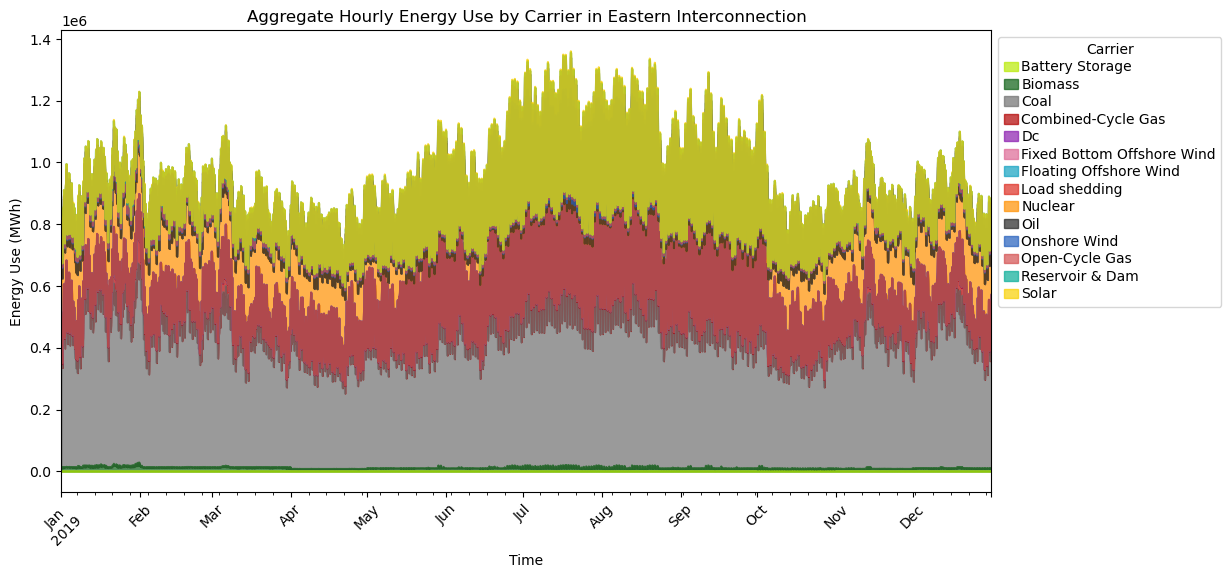

In [1112]:
# create dictionary mapping carriers.nice_name and carriers.color
carrier_colors = (carriers[["nice_name", "color"]]
.set_index("nice_name")
.to_dict()["color"])

def plot_energy_use_by_carrier(energy_use_zonal: pd.DataFrame, interconnect: str):
    """
    Plots energy use by carrier for a given interconnect.
    """
    # Select data for interconnect
    data = energy_use_zonal.loc(axis=0)[:, :, :, :, interconnect].groupby(["carrier"]).sum().T

    # Plot data. Use get_color_palette() to get a list of colors for the plot.
    fig, ax = plt.subplots(figsize=(12, 6))
    data.plot.area(ax=ax, color=[carrier_colors[carrier] for carrier in data.columns], alpha=0.7)
    ax.set_title(f"Aggregate Hourly Energy Use by Carrier in {interconnect} Interconnection")
    ax.set_xlabel("Time")
    ax.set_ylabel("Energy Use (MWh)")
    ax.legend(title="Carrier", bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    plt.show()

# Plot energy use by carrier for the specified interconnection
plot_energy_use_by_carrier(energy_use_zonal, "Eastern")


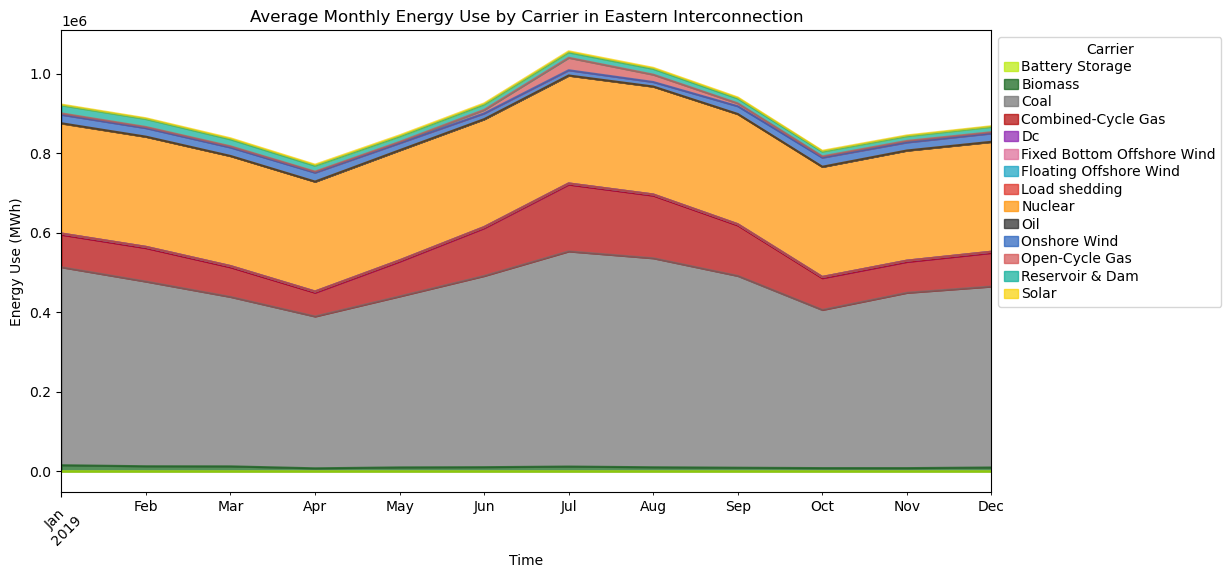

In [1111]:
def plot_energy_use_by_carrier_monthly(energy_use_zonal_monthly: pd.DataFrame, interconnect: str):
    """
    Plots energy use by carrier for a given interconnect.
    """
    # Select data for interconnect
    data = energy_use_zonal_monthly.loc(axis=0)[:, :, :, :, interconnect].groupby(["carrier"]).sum().T

    # Plot data
    fig, ax = plt.subplots(figsize=(12, 6))
    data.plot.area(ax=ax, color=[carrier_colors[carrier] for carrier in data.columns], alpha=0.7)
    ax.set_title(f"Average Monthly Energy Use by Carrier in {interconnect} Interconnection")
    ax.set_xlabel("Time")
    ax.set_ylabel("Energy Use (MWh)")
    ax.legend(title="Carrier", bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    plt.show()

# Plot energy use by carrier aggregated by month for specified interconnection
plot_energy_use_by_carrier_monthly(energy_use_zonal_monthly, "Eastern")

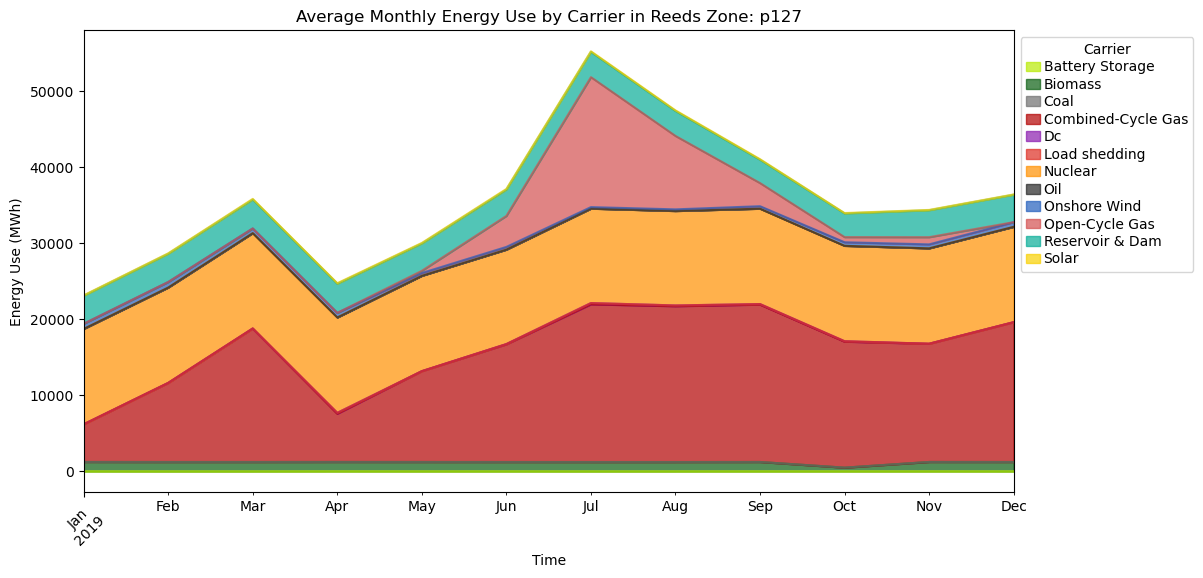

In [1114]:
def plot_energy_use_by_carrier_zone(energy_use_zonal: pd.DataFrame, reeds_zone: str):
    """
    Plots energy use by carrier for a given reeds zone.
    """
    # Select data for reeds zone
    data = energy_use_zonal.loc(axis=0)[:, :, reeds_zone, :, :].groupby(["carrier"]).sum().T

    # Plot data
    fig, ax = plt.subplots(figsize=(12, 6))
    data.plot.area(ax=ax, color=[carrier_colors[carrier] for carrier in data.columns], alpha=0.7)
    ax.set_title(f"Average Monthly Energy Use by Carrier in Reeds Zone: {reeds_zone}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Energy Use (MWh)")
    ax.legend(title="Carrier", bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    plt.show()

# Plot energy use by carrier and reeds zone
plot_energy_use_by_carrier_zone(energy_use_zonal_monthly, "p127") #p127 is an NY Reeds Zone


### Energy Demand Statistics

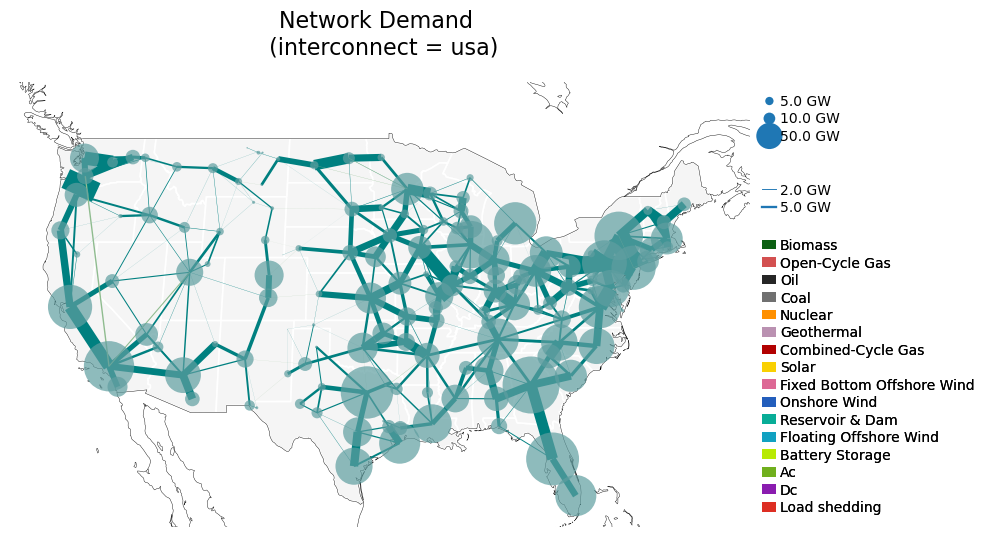

In [1041]:
from plot_network_maps import plot_demand_map
import warnings
warnings.filterwarnings("ignore")

# Drop carrier type legend 


# plot demand map
plot_demand_map(
    n=network,
    regions=gdf_states,
    carriers=["solar", "wind", "onwind", "offwind", "ror", "nuclear", "gas", "coal", "battery"],
    save="C:/Users/alexa/Policy_Integrity/figures/USA_demand_map.png",
    interconnect="usa",
)

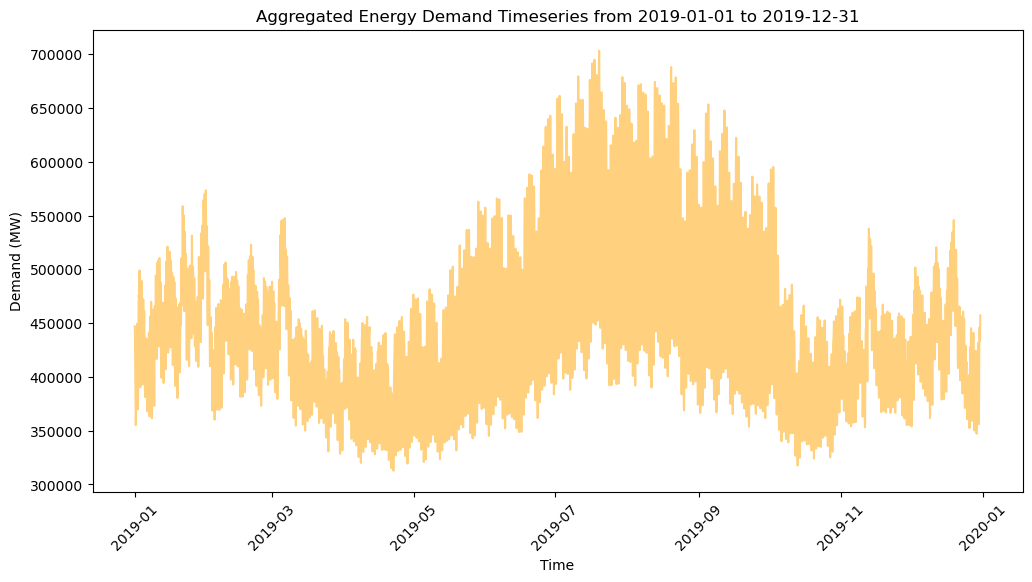

In [725]:
from summary import get_demand_timeseries, get_demand_base

# Get demand timeseries
demand_timeseries = get_demand_timeseries(network)

# Reset index then change timestep column to datetime object
demand_timeseries = demand_timeseries.reset_index()
demand_timeseries["timestep"] = pd.to_datetime(demand_timeseries["timestep"], format="%Y-%m-%d %H:%M:%S")

# Function to plot demand timeseries for a specified window of time. Dont include period in legend
def plot_demand_timeseries(demand_timeseries: pd.DataFrame, start_date: str, end_date: str):
    """
    Plots demand timeseries for a specified window of time.
    """
    # Select data for specified window of time
    data = demand_timeseries[(demand_timeseries["timestep"] >= start_date) & (demand_timeseries["timestep"] <= end_date)]

    # Plot demand
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.plot(data["timestep"], 
    data["Demand"], 
    label="Demand (MWh)", 
    color="orange",
    alpha=0.5)
    ax.set_title(f"Aggregated Energy Demand Timeseries from {start_date} to {end_date}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Demand (MW)")
    plt.xticks(rotation=45)
    plt.show()


# Plot demand timeseries. Change start_date and end_date parameters to desired time period.
plot_demand_timeseries(demand_timeseries, "2019-01-01", "2019-12-31")

In [999]:
# Load data
loads_t = pd.DataFrame(network.loads_t.p)
loads_t.head()

generator                   p1000 0 AC   p101 0 AC  p1010 0 AC  p1020 0 AC  \
period timestep                                                              
2019   2019-01-01 00:00:00  327.730988  14165.4718  18934.5186  11420.2543   
       2019-01-01 01:00:00  315.845703  15897.4117  17811.2813  10742.7787   
       2019-01-01 02:00:00  303.081512  17081.6269  16506.7915   9955.9835   
       2019-01-01 03:00:00  287.672607  16906.3749  15268.1887   9208.9265   
       2019-01-01 04:00:00  278.005188  16493.5124  14158.5234   8539.6374   

generator                   p1030 0 AC  p1040 0 AC   p1050 0 AC   p1060 0 AC  \
period timestep                                                                
2019   2019-01-01 00:00:00  11073.0685  721.149292  5960.015625  1897.593628   
       2019-01-01 01:00:00  10925.5921  703.946716  5854.692383  1872.320679   
       2019-01-01 02:00:00  10636.5742  680.870178  5684.607422  1822.791748   
       2019-01-01 03:00:00  10372.0424  655.984802  5516.077148  1777.458618   
       2019-01-01 04:00:00  10065.7696  635.429016  5349.146973  1724.972656   

generator                    p1070 0 AC  p1080 0 AC  ...    p91 0 AC  \
period timestep                                      ...               
2019   2019-01-01 00:00:00  3293.354004  783.064697  ...  10938.5466   
       2019-01-01 01:00:00  3248.980225  771.522705  ...  12308.2784   
       2019-01-01 02:00:00  3162.278320  749.130493  ...  13198.4690   
       2019-01-01 03:00:00  3083.216064  729.683777  ...  13054.3086   
       2019-01-01 04:00:00  2991.590576  706.500122  ...  12722.0522   

generator                     p910 0 AC  p920 0 AC    p930 0 AC   p940 0 AC  \
period timestep                                                               
2019   2019-01-01 00:00:00  1444.928345  9502.7726  1206.977417  17794.2743   
       2019-01-01 01:00:00  1402.901245  9315.2851  1179.524902  17282.6740   
       2019-01-01 02:00:00  1337.574219  8960.6639  1135.936035  16483.4564   
       2019-01-01 03:00:00  1257.343140  8693.0065  1097.271240  15513.5179   
       2019-01-01 04:00:00  1225.680054  8347.1018  1056.811890  15113.6379   

generator                     p950 0 AC    p960 0 AC    p970 0 AC  \
period timestep                                                     
2019   2019-01-01 00:00:00  3271.219727  5871.688477  7588.851562   
       2019-01-01 01:00:00  3175.596680  5700.047363  7367.691895   
       2019-01-01 02:00:00  3063.847412  5499.465332  7108.224121   
       2019-01-01 03:00:00  2971.609863  5333.902344  6894.247559   
       2019-01-01 04:00:00  2804.416992  5033.797363  6507.423828   

generator                     p980 0 AC   p990 0 AC  
period timestep                                      
2019   2019-01-01 00:00:00  7372.194336  10559.8712  
       2019-01-01 01:00:00  7153.900879  10176.9274  
       2019-01-01 02:00:00  6900.157715   9765.6462  
       2019-01-01 03:00:00  6684.815430   9269.1650  
       2019-01-01 04:00:00  6316.599609   8957.6588  

[5 rows x 145 columns]

### Ouput (Dispatch Scenario)

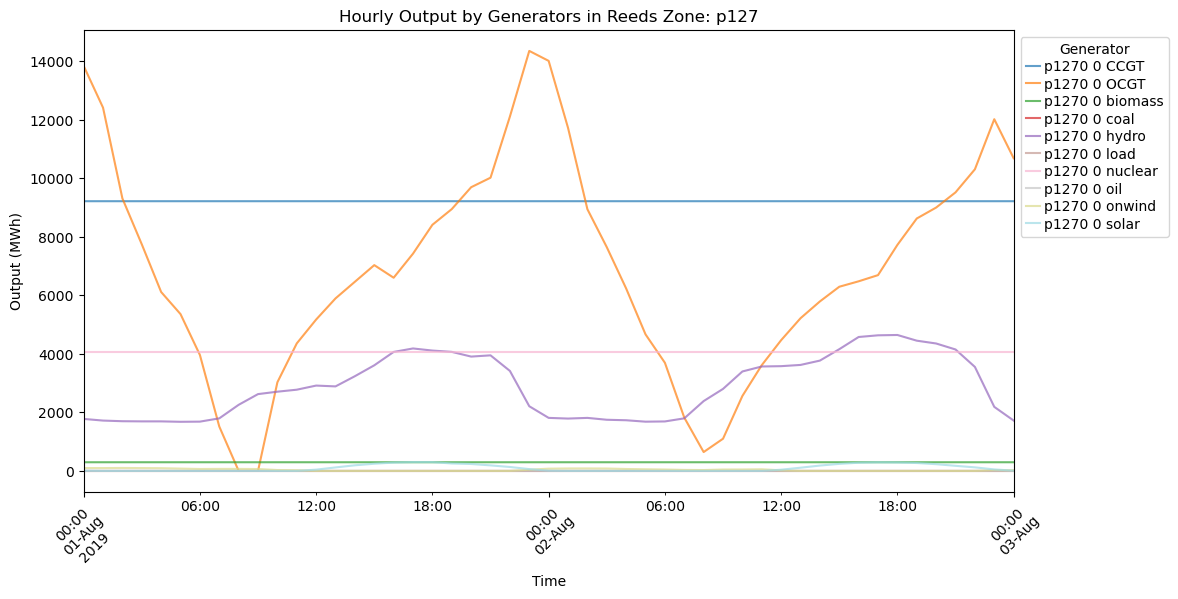

In [1115]:
def generator_add_zonal(generator):
    """
    Takes specific generation data and returns a dataframe with geographic features features.
    """
    generator_zonal = generator.T

    # Make columns starting at 0 a timestep of 2019
    generator_zonal.columns = pd.date_range(start="2019-01-01", 
    periods=len(generator_zonal.columns), 
    freq="H")

    generator_zonal.index.name = "generator"
    generator_zonal = generator_zonal.reset_index()
 
    generator_zonal["bus"] = generator_zonal["generator"].map(network.generators.bus)
    generator_zonal["reeds_zone"] = generator_zonal["bus"].map(buses.reeds_zone)
    generator_zonal["reeds_ba"] = generator_zonal["bus"].map(buses.reeds_ba)
    generator_zonal["interconnect"] = generator_zonal["bus"].map(buses.interconnect)
    generator_zonal["reeds_state"] = generator_zonal["bus"].map(buses.reeds_state)

    cols = generator_zonal.columns.tolist()
    cols = cols[-5:] + cols[:-5]
    generator_zonal = generator_zonal[cols]

    generator_zonal = generator_zonal.set_index(["bus", "reeds_zone", "reeds_ba", "interconnect", "reeds_state", "generator"])

    return generator_zonal

# Import generators-p data: Active power at bus (positive if net generation)
generators_p = (generator_add_zonal(network.generators_t.p)
                .groupby(["reeds_zone", "generator"]) # Change groupby to desired setting (i.e reeds_state). Update plotting function accordingly.
                .mean()) 

def plot_generators_p(generator:pd.DataFrame, reeds_zone: str, start_date: str, end_date: str):
    """
    Plots generator data for a specified reeds zone and time period.
    """
    generator.columns = pd.date_range(start="2019-01-01", 
    periods=len(generator.columns), 
    freq="H")

    # Select data for reeds zone
    data = generator.loc(axis=0)[reeds_zone].T
    data = data[(data.index >= start_date) & (data.index <= end_date)]

    # Plot data
    fig, ax = plt.subplots(figsize=(12, 6))
    data.plot(ax=ax, cmap="tab20", alpha=0.7)
    ax.set_title(f"Hourly Output by Generators in Reeds Zone: {reeds_zone}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Output (MWh)")
    ax.legend(title="Generator", bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    plt.show()

# plot marginal cost by generator for specified reeds_zone and time period
plot_generators_p(generators_p, 'p127', "2019-08-01", "2019-08-03")

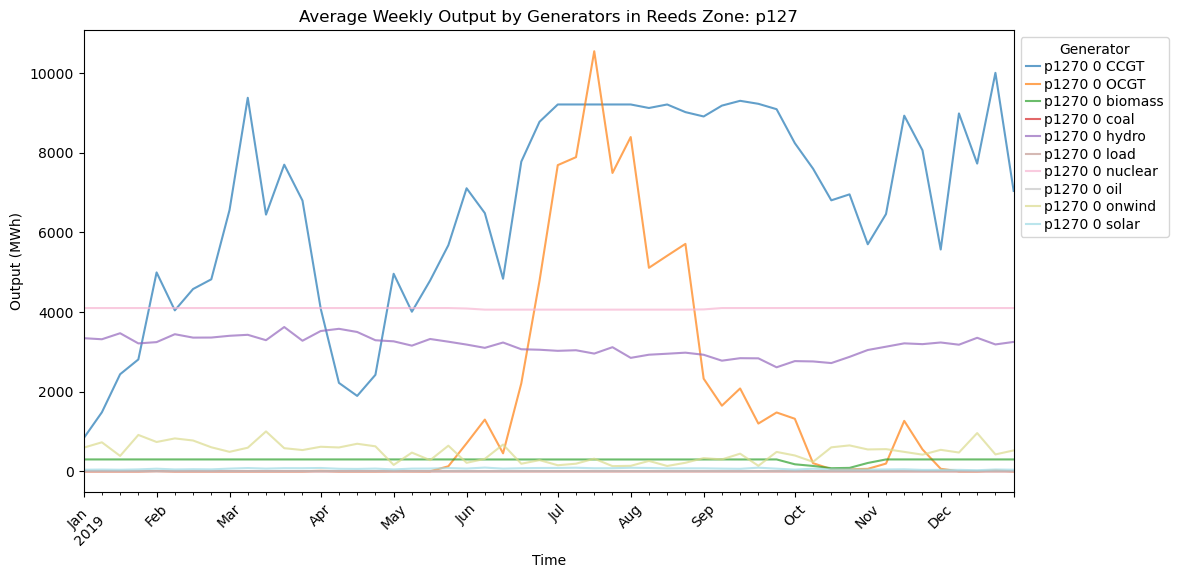

In [1116]:
# Generators_p weekly average 
generators_p_weekly = generators_p.resample("W", axis=1).mean()

def plot_generators_p_weekly(generator:pd.DataFrame, reeds_zone: str, start_date: str, end_date: str):
    """
    Plots generator data for a specified reeds zone and time period.
    """
    # Select data for reeds zone
    data = generator.loc(axis=0)[reeds_zone].T
    data = data[(data.index >= start_date) & (data.index <= end_date)]

    # Plot data
    fig, ax = plt.subplots(figsize=(12, 6))
    data.plot(ax=ax, cmap="tab20", alpha=0.7)
    ax.set_title(f"Average Weekly Output by Generators in Reeds Zone: {reeds_zone}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Output (MWh)")
    ax.legend(title="Generator", bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    plt.show()


plot_generators_p_weekly(generators_p_weekly, "p127", "2019-01-06", "2019-12-29")

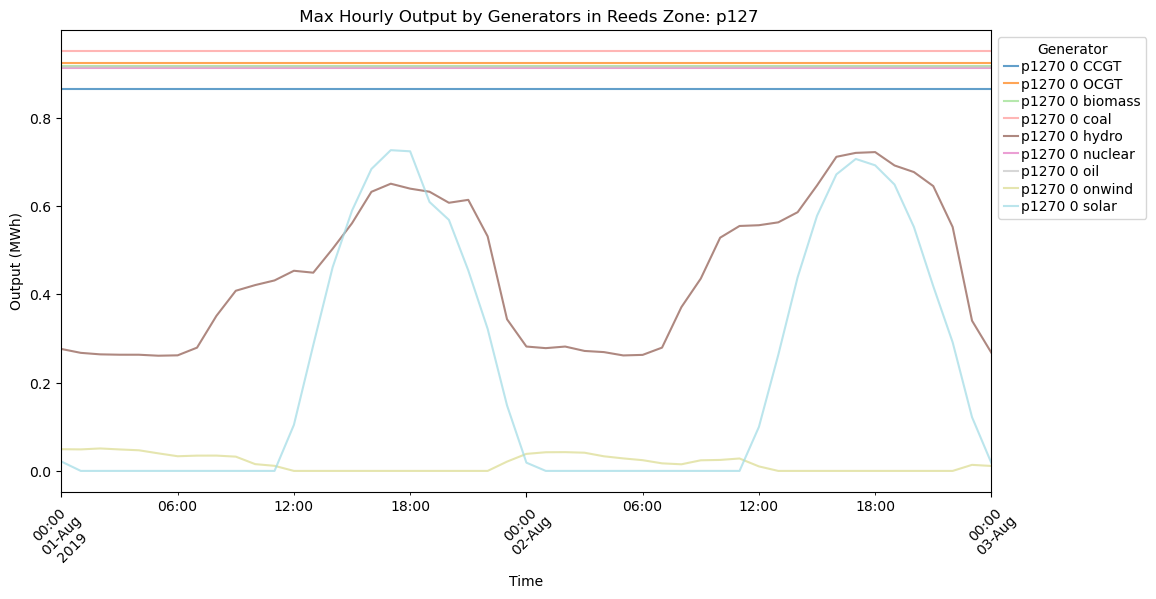

In [1117]:
# Import generators-p_max_pu data: The maximum output for each snapshot per unit of p_nom for the optimization 
# (e.g. for variable renewable generators this can change due to weather conditions; for conventional generators it represents a maximum dispatch).
generators_p_max = (generator_add_zonal(network.generators_t.p_max_pu)
                .groupby(["reeds_zone", "generator"]) # Change groupby to desired setting (i.e reeds_state). Will require plot functions to be updated accordingly.
                .sum()) 


def plot_generators_p_max(generator:pd.DataFrame, reeds_zone: str, start_date: str, end_date: str):
    """
    Plots generator data for a specified reeds zone and time period.
    """
    generator.columns = pd.date_range(start="2019-01-01", 
    periods=len(generator.columns), 
    freq="H")

    # Select data for reeds zone
    data = generator.loc(axis=0)[reeds_zone].T
    data = data[(data.index >= start_date) & (data.index <= end_date)]

    # Plot data
    fig, ax = plt.subplots(figsize=(12, 6))
    data.plot(ax=ax, cmap="tab20", alpha=0.7)
    ax.set_title(f" Max Hourly Output by Generators in Reeds Zone: {reeds_zone}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Output (MWh)")
    ax.legend(title="Generator", bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    plt.show()

# plot marginal cost by generator for specified reeds_zone and time period
plot_generators_p_max(generators_p_max, 'p127', "2019-08-01", "2019-08-03")

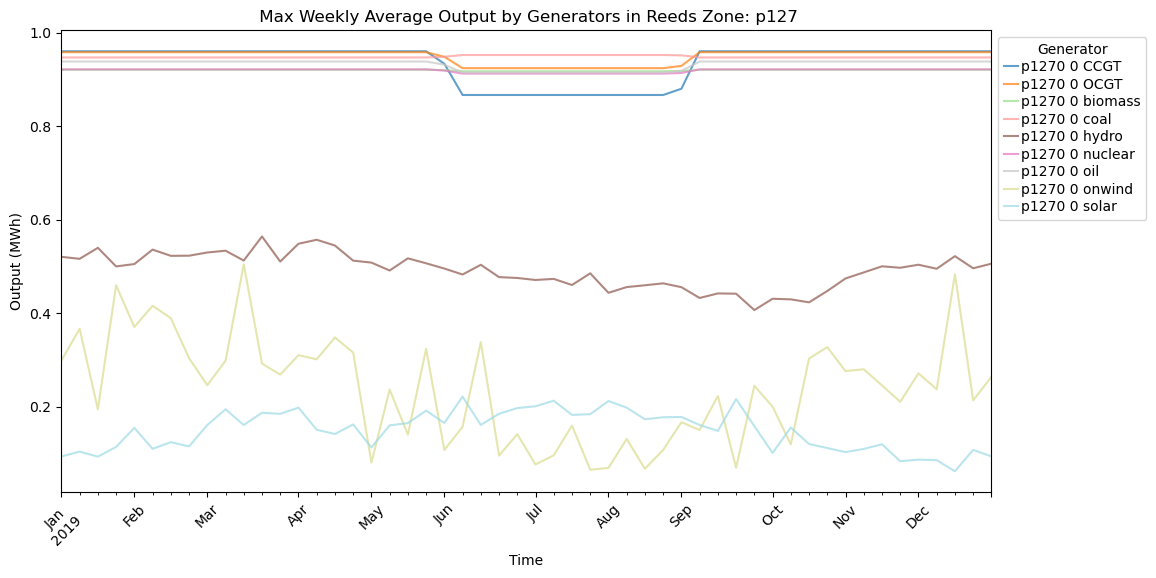

In [1118]:
# generators_p_max weekly average output
generators_p_max_monthly = (generators_p_max
                        .resample("W", axis=1)
                        .mean()
)

def plot_generators_p_max(generator:pd.DataFrame, reeds_zone: str, start_date: str, end_date: str):
    """
    Plots generator data for a specified reeds zone and time period.
    """
    # Select data for reeds zone
    data = generator.loc(axis=0)[reeds_zone].T
    data = data[(data.index >= start_date) & (data.index <= end_date)]

    # Plot data
    fig, ax = plt.subplots(figsize=(12, 6))
    data.plot(ax=ax, cmap="tab20", alpha=0.7)
    ax.set_title(f" Max Weekly Average Output by Generators in Reeds Zone: {reeds_zone}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Output (MWh)")
    ax.legend(title="Generator", bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    plt.show()

plot_generators_p_max(generators_p_max_monthly, 'p127', "2019-01-06", "2019-12-29")

### Marginal Cost Statistics

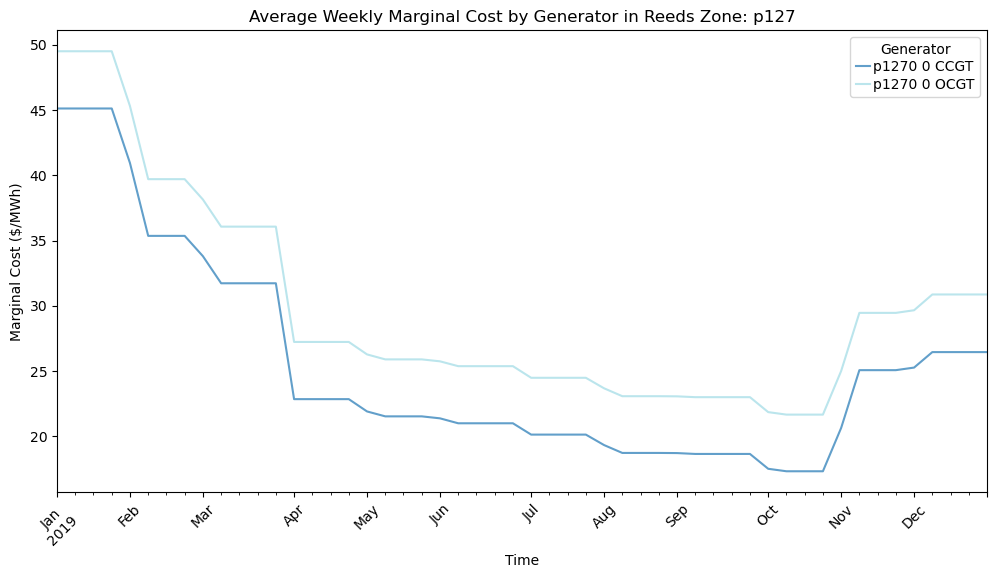

In [1127]:
# Import generators_t_marginal_cost data: Marginal cost of production of 1 MWh.
generators_mc = (generator_add_zonal(network.generators_t.marginal_cost)
                .groupby(["reeds_zone", "generator"]) # Change groupby to desired setting (i.e reeds_state). Will require plot functions to be updated accordingly.
                .sum())

def plot_generators_mc_weekly(generator:pd.DataFrame, reeds_zone: str, start_date: str, end_date: str):
    """
    Plots average weekly marginal cost by generator for a specified reeds zone and time period.
    """
    generator.columns = pd.date_range(start="2019-01-01", 
    periods=len(generator.columns), 
    freq="H")

    generators_weekly = (generator
                        .resample("W", axis=1)
                        .mean())

    # Select data for reeds zone
    data = generators_weekly.loc(axis=0)[reeds_zone].T
    data = data[(data.index >= start_date) & (data.index <= end_date)]

    # Plot data
    fig, ax = plt.subplots(figsize=(12, 6))
    data.plot(ax=ax, cmap="tab20", alpha=0.7)
    ax.set_title(f"Average Weekly Marginal Cost by Generator in Reeds Zone: {reeds_zone}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Marginal Cost ($/MWh)")
    ax.legend(title="Generator", bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    plt.show()


# Plot marginal cost by generator for specified reeds_zone and time period
plot_generators_mc_weekly(generators_mc, 'p127', "2019-01-01", "2019-12-31")

In [994]:
network.storage_units_t.p_dispatch

StorageUnit                 p101 0 battery  p1010 0 battery  p1020 0 battery  \
period timestep                                                                
2019   2019-01-01 00:00:00        0.055230        31.547243         7.116447   
       2019-01-01 01:00:00       89.893218        10.371354         6.136821   
       2019-01-01 02:00:00       68.851944        10.235511         5.722882   
       2019-01-01 03:00:00       63.395944        11.608143         5.709302   
       2019-01-01 04:00:00       68.490626        16.819391         6.114705   
...                                    ...              ...              ...   
       2019-12-31 19:00:00        0.020478         0.033011         0.031417   
       2019-12-31 20:00:00        0.003700         0.028771         0.027967   
       2019-12-31 21:00:00        0.003792         0.025362         0.024996   
       2019-12-31 22:00:00        0.020322         0.022447         0.022259   
       2019-12-31 23:00:00        0.020630         0.019652         0.019344   

StorageUnit                 p1040 0 battery  p1050 0 battery  p1060 0 battery  \
period timestep                                                                 
2019   2019-01-01 00:00:00         0.086262         0.109448         0.112620   
       2019-01-01 01:00:00         0.086840         0.108123         0.111892   
       2019-01-01 02:00:00         0.084899         0.100539         0.100760   
       2019-01-01 03:00:00         0.085432         0.100637         0.100069   
       2019-01-01 04:00:00         0.074892         0.075914         0.074981   
...                                     ...              ...              ...   
       2019-12-31 19:00:00         0.084939         0.094103         0.090136   
       2019-12-31 20:00:00         0.083580         0.093745         0.091335   
       2019-12-31 21:00:00         0.081186         0.091410         0.091030   
       2019-12-31 22:00:00         0.106663         0.102432         0.102627   
       2019-12-31 23:00:00         0.101563         0.105759         0.109668   

StorageUnit                 p1070 0 battery  p11 0 battery  p111 0 battery  \
period timestep                                                              
2019   2019-01-01 00:00:00         0.114593       0.226592        0.053012   
       2019-01-01 01:00:00         0.115298       0.093537       48.285927   
       2019-01-01 02:00:00         0.096183       0.069294       36.265040   
       2019-01-01 03:00:00         0.096723       0.056174       33.629556   
       2019-01-01 04:00:00         0.077710       0.047558       36.524524   
...                                     ...            ...             ...   
       2019-12-31 19:00:00         0.110691       0.050317        0.019756   
       2019-12-31 20:00:00         0.111130       0.005674        0.003450   
       2019-12-31 21:00:00         0.111235       0.006997        0.003725   
       2019-12-31 22:00:00         0.113895       0.044427        0.019479   
       2019-12-31 23:00:00         0.123198       0.036002        0.020113   

StorageUnit                 p1120 0 battery  ...  p642 0 battery  \
period timestep                              ...                   
2019   2019-01-01 00:00:00         0.075575  ...        0.764572   
       2019-01-01 01:00:00         0.075652  ...        0.732029   
       2019-01-01 02:00:00         0.075700  ...        0.923484   
       2019-01-01 03:00:00         0.075696  ...        0.470727   
       2019-01-01 04:00:00         0.075588  ...        0.023960   
...                                     ...  ...             ...   
       2019-12-31 19:00:00         0.084219  ...        0.038814   
       2019-12-31 20:00:00         0.084133  ...        0.037050   
       2019-12-31 21:00:00         0.084046  ...        0.035178   
       2019-12-31 22:00:00         0.083971  ...        0.032879   
       2019-12-31 23:00:00         0.083752  ...        0.029592   

Stora

In [995]:
network.storage_units_t.state_of_charge

StorageUnit                 p101 0 battery  p1010 0 battery  p1020 0 battery  \
period timestep                                                                
2019   2019-01-01 00:00:00      395.753775        51.746961        32.500691   
       2019-01-01 01:00:00      301.009162        40.828474        26.046112   
       2019-01-01 02:00:00      228.443812        30.053087        20.027875   
       2019-01-01 03:00:00      161.629538        17.830898        14.023987   
       2019-01-01 04:00:00       89.444941         0.115731         7.592887   
...                                    ...              ...              ...   
       2019-12-31 19:00:00        8.014576        84.723224        39.697655   
       2019-12-31 20:00:00      161.029069        84.739557        39.720742   
       2019-12-31 21:00:00      314.042294        84.771524        39.759770   
       2019-12-31 22:00:00      320.710646        84.830561        39.826034   
       2019-12-31 23:00:00      395.797302        84.989910        39.987910   

StorageUnit                 p1040 0 battery  p1050 0 battery  p1060 0 battery  \
period timestep                                                                 
2019   2019-01-01 00:00:00         0.487260         1.051386        11.971271   
       2019-01-01 01:00:00         0.484489         1.016932        11.937086   
       2019-01-01 02:00:00         0.486060         0.995163        11.922625   
       2019-01-01 03:00:00         0.486443         0.973117        11.909481   
       2019-01-01 04:00:00         0.514881         1.010569        11.966465   
...                                     ...              ...              ...   
       2019-12-31 19:00:00         0.541573         1.154227        12.041296   
       2019-12-31 20:00:00         0.546769         1.146241        12.047422   
       2019-12-31 21:00:00         0.557412         1.142832        12.054250   
       2019-12-31 22:00:00         0.519017         1.118147        12.036738   
       2019-12-31 23:00:00         0.488912         1.087838        12.006521   

StorageUnit                 p1070 0 battery  p11 0 battery  p111 0 battery  \
period timestep                                                              
2019   2019-01-01 00:00:00         4.655437      13.176398      213.455050   
       2019-01-01 01:00:00         4.618089      13.109779      162.567648   
       2019-01-01 02:00:00         4.616164      13.073071      124.351189   
       2019-01-01 03:00:00         4.613155      13.055077       88.912668   
       2019-01-01 04:00:00         4.665927      13.052120       50.422498   
...                                     ...            ...             ...   
       2019-12-31 19:00:00         4.837258       0.926962        6.727385   
       2019-12-31 20:00:00         4.806833       6.985883       89.729675   
       2019-12-31 21:00:00         4.776223      13.041537      172.729971   
       2019-12-31 22:00:00         4.741152      13.133272      178.206304   
       2019-12-31 23:00:00         4.691582      13.388801      213.497056   

StorageUnit                 p1120 0 battery  ...  p642 0 battery  \
period timestep                              ...                   
2019   2019-01-01 00:00:00         5.843087  ...        2.204777   
       2019-01-01 01:00:00         5.880455  ...        1.454067   
       2019-01-01 02:00:00         5.917912  ...        0.501099   
       2019-01-01 03:00:00         5.955533  ...        0.026138   
       2019-01-01 04:00:00         5.993660  ...        0.739623   
...                                     ...  ...             ...   
       2019-12-31 19:00:00         5.757124  ...        2.287049   
       2019-12-31 20:00:00         5.768813  ...        2.376216   
       2019-12-31 21:00:00         5.780739  ...        2.491022   
       2019-12-31 22:00:00         5.792905  ...        2.656105   
       2019-12-31 23:00:00         5.805673  ...        2.990124   

Stora

In [998]:
network.lines

,bus0,bus1,r,x,b,s_nom,v_nom,interconnect,carrier,underwater_fraction,...,build_year,lifetime,terrain_factor,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu
Line,,,,,,,,,,,,,,,,,,,,,
0,p1000 0,p1160 0,0.744932,6.964900,0.000108,5753.80,230.0,Eastern,AC,0.0,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
1,p1000 0,p990 0,0.659663,4.875374,0.000098,6796.30,230.0,Eastern,AC,0.0,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
10,p1030 0,p1040 0,0.251041,3.674778,0.000240,10844.84,230.0,Eastern,AC,0.0,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
100,p1300 0,p1340 0,0.243920,2.864887,0.000402,16695.64,230.0,Eastern,AC,0.0,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
101,p131 0,p251 0,2.149952,38.249655,0.000190,3709.90,230.0,Western,AC,0.0,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,p1280 0,p1330 0,inf,inf,0.000000,0.00,230.0,Eastern,AC,0.0,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
96,p1290 0,p1300 0,0.117259,1.581328,0.000335,20168.66,230.0,Eastern,AC,0.0,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
97,p1290 0,p1310 0,0.367609,5.172190,0.000294,10609.09,230.0,Eastern,AC,0.0,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
